In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [43]:
data = pd.read_csv("data.csv")
data_train = data.iloc[4:15]
data_test = data.iloc[12:15]

In [44]:
data

,A,B1,B2,A_doithu,B_doithu
0,0,0,0,180315,5403820
1,0,0,0,293248,11458146
2,0,0,0,177016,18438880
3,0,0,0,327871,10013404
4,735,450,560,181098,4864172
5,330,350,600,270405,10889213
6,560,360,630,90514,4774831
7,750,420,805,355380,9768208
8,730,450,850,202572,6012674
9,450,400,750,244208,9402112


In [45]:
def matrix_L(alpha, beta, gamma,period, size = 2):
    L = np.zeros((size, size), dtype = float)
    for i in range(size):
        for j in range(i+1):
            if j==i:
                L[i][j] = 1
            else:
                L[i][j] = alpha * (1 + (i-j)* beta) + gamma * (1 if i % period == j % period  else 0)

    return L

def matrix_M(n, p):
    first_col = np.arange(n)  # Create the first column

    # Create blocks of identity matrices
    identity_blocks = np.vstack([np.eye(p) for _ in range(int(np.ceil(n / p)))])
    identity_blocks = identity_blocks[:n, :]  # Trim to match n rows

    # Assemble the matrix
    M = np.hstack([first_col[:, np.newaxis], identity_blocks])
    return M

def matrix_X(L, M):
    return np.linalg.inv(L) @ M

def obj_function_result(alpha, beta, gamma, period, inp):
    data = np.array(inp, ndmin = 2, dtype = float)
    Y = data.transpose()
    L = matrix_L(alpha, beta, gamma,period, len(inp))
    M = matrix_M(len(inp), period)
    X = matrix_X(L, M)
    Px = X @ np.linalg.inv(np.transpose(X) @ X) @ np.transpose(X)
    return np.transpose(np.linalg.inv(L) @ Y) @ (np.eye(len(inp)) - Px) @ np.linalg.inv(L) @ Y

def sum_obj_function_result(params, *args):
    alpha, beta, gamma = params
    period, data = args
    columns = data.columns
    return sum([ obj_function_result(alpha, beta, gamma, period, data[i]) for i in columns])

def psi(M, L, X, Y):
    return np.linalg.inv(X.T @ X) @ X.T @ (np.linalg.inv(L)).T @ Y.T

def psis(alpha, beta, gamma, period, data):
    columns = data.columns
    return [psi(matrix_M(len(data), period),matrix_L(alpha, beta, gamma, period, len(data)),matrix_X(matrix_L(alpha, beta, gamma, period, len(data)), matrix_M(len(data), period)), np.array(data[i], ndmin = 2, dtype = float)) for i in columns ]


def preidict_Holt(alpha, beta, gamma, period, data_train, step = 1):
    ppsis = psis(alpha, beta, gamma, period, data_train)
    columns = data_train.columns
    results_results = []
    app_app = []
    for i in range(len(columns)):
        l = np.arange(len(data_train)+1)
        l[0] = -ppsis[i][0]
        b = np.arange(len(data_train)+1)
        b[0] = ppsis[i][0]
        s = {}
        app = np.arange(len(data_train)+1)
        for j in range(period):
            s[j+1-4] = ppsis[i][j+1]
        for j in range(len(data_train)-1):
            s[i+1] = 0
        app[1] = l[0] + b[0] + s[0]
        data = np.array(data_train[columns[i]])
        d = period
        for i in range(0,len(data_train)):
            l[i+1] = alpha*(data[i]-s[i+1-d]) + (1-alpha)*(l[i]+b[i])
            b[i+1] = beta * (l[i+1]-l[i]) + (1-beta)*b[i]
            s[i+1] = gamma*(data[i]-l[i]-b[i]) + (1-gamma)*s[i+1-d]
            app[i+1] = l[i] + b[i] +s[i]
        app_app.append(app[1:])
        results = []
        for i in range(step):
            tmp = l[len(data_train)] + (i+1)* b[len(data_train)] + s[len(data_train)+i +1- d*(1+(i) //d)]
            results.append(list(tmp))
        results_results.append(results)
    return results_results, app_app

def sum_obj_MSE(params, *args):
    alpha, beta, gamma = params
    period, data = args
    columns = data.columns
    _, results =  preidict_Holt(alpha, beta, gamma, period, data)
    j = 0
    MSE = []
    for i in columns:
        MSE.append(mean_squared_error(data[i], results[j]))
        j = j+1
    coeff  = [3,3,3,1,1]
    return np.dot(np.array(MSE, dtype= float), np.array(coeff, dtype = float)) / sum(coeff)


In [46]:
initial_values = np.array([0.1, 0.1, 0.1])
boundaries = [(0, 1), (0, 1), (0,1)]
parameters = fmin_l_bfgs_b(
sum_obj_function_result, x0=initial_values, args=(4, data_train), bounds=boundaries, approx_grad=True
)
alpha, beta, gamma = parameters[0]
predict0,re0 = preidict_Holt(alpha, beta, gamma, 4, data_train, step = 4)


In [47]:
j = 0
for i in data_test.columns:
    print(f'cột {i}: MAE = {mean_absolute_error(re0[j], data_train[i])}')
    j = j+1

cột A: MAE = 124.27272727272727
cột B1: MAE = 90.81818181818181
cột B2: MAE = 161.63636363636363
cột A_doithu: MAE = 76025.63636363637
cột B_doithu: MAE = 3034152.909090909


In [56]:
def plot_evaluate(train, prediction):
    train_range = list(range(4, len(train) + 4))
    prediction_range  = list(range(len(train) + 4, len(train) + len(prediction) + 4))
    markers = ['o', 'v', '^', 's', 'p']

    figre, axs = plt.subplots(1, len(train.columns), figsize = (28, 7))
    for i, feature in enumerate(train.columns):
        axs[i].plot(train_range, train[feature], label=f'Train-{feature}', marker=markers[i])
        axs[i].plot(prediction_range, prediction[i], label=f'Predict-{feature}', marker=markers[i])

        axs[i].set_xlabel('time')
        axs[i].set_ylabel(feature)
        axs[i].set_title(f'Biểu đồ biểu diễn {feature}')
        axs[i].legend()
        axs[i].grid(True)
        # axs[i].show()
    return figre
#Định nghĩa một số hàm cần dùng
def plot_predict(prediction, data_name):
    markers = ['o', 'v', '^', 's', 'p']

    figre, axs = plt.subplots(1, len(data_name), figsize = (30, 7))
    for i, feature in enumerate(data_name):
        axs[i].plot(prediction[i], label=f'Predict-{feature}', marker=markers[i])
        axs[i].set_xlabel('time')
        axs[i].set_ylabel(feature)
        axs[i].set_title(f'Dự báo {feature}')
        axs[i].legend()
        axs[i].grid(True)
        # axs[i].show()
    return figre

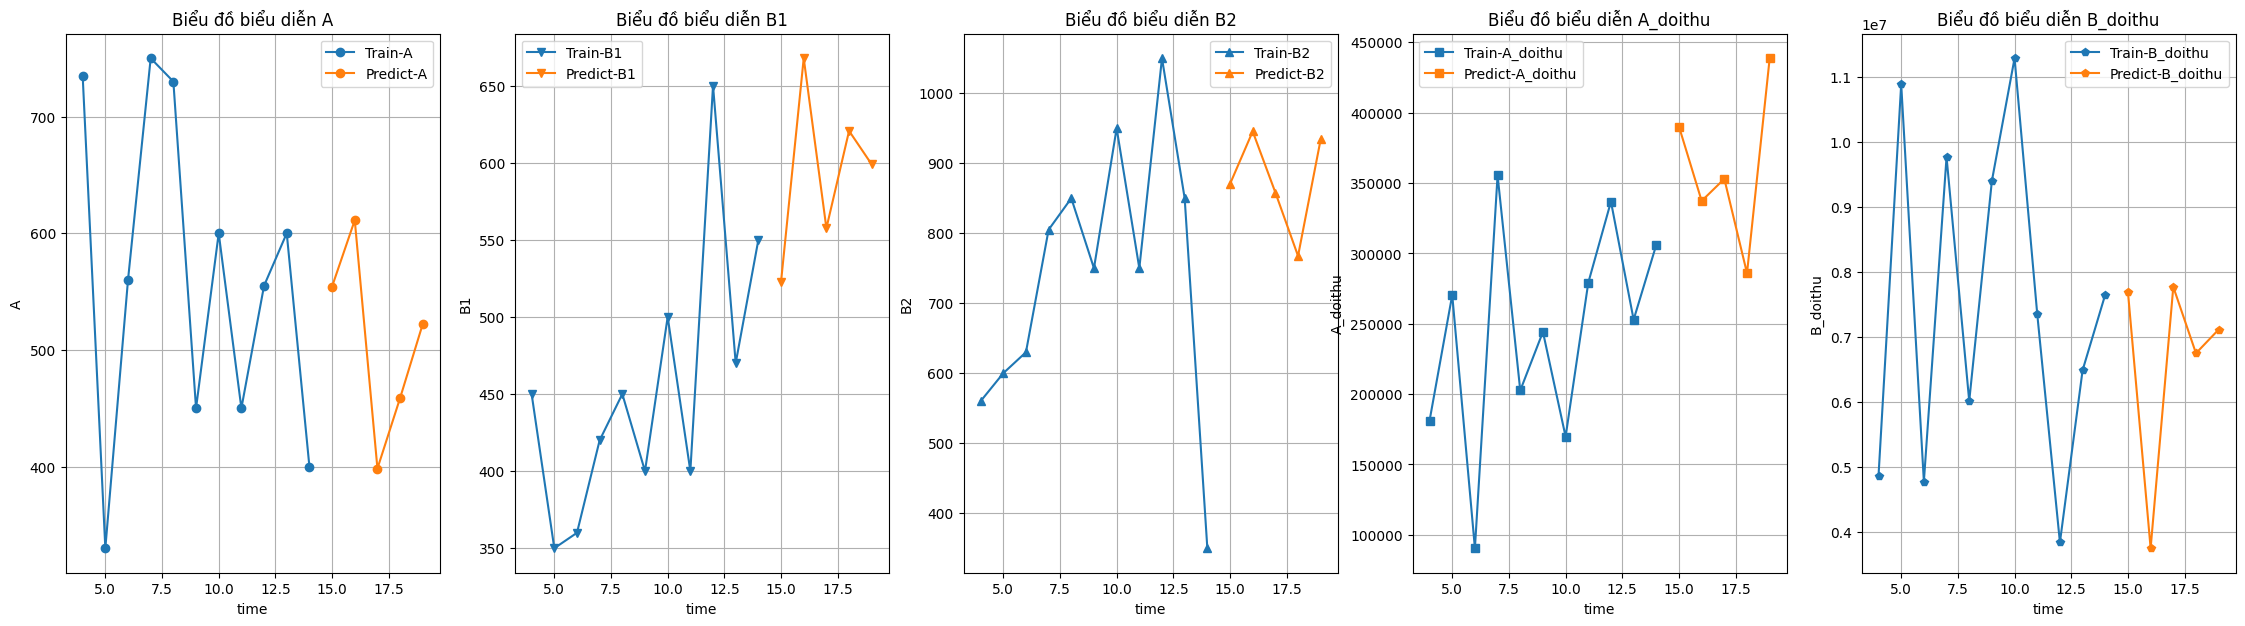

In [57]:
features = ['A', 'B1', 'B2', 'A_doithu', 'B_doithu']
data_train = data.iloc[4:15]
data_test = data.iloc[11:15]
data_train = data_train[features]
data_test= data_test[features]

initial_values = np.array([0.1, 0.1, 0.1])
boundaries = [(0, 1), (0, 1), (0,1)]
parameters = fmin_l_bfgs_b(
sum_obj_function_result, x0=initial_values, args=(4, data_train), bounds=boundaries, approx_grad=True
)
alpha, beta, gamma = parameters[0]
predict0,re0 = preidict_Holt(alpha, beta, gamma, 4, data_train, step = 5)

j = 0
# for i in data_test.columns:
#     print(f'cột {i}: MAE = {mean_absolute_error(predict0[j], data_test[i])}')
#     j = j+1

figre = plot_evaluate(data_train, predict0)


cột A: MAE = 153.79953379953386
cột B1: MAE = 204.13986013986008
cột B2: MAE = 207.80652680652673
cột A_doithu: MAE = 158912.0699300699
cột B_doithu: MAE = 3293235.3729603724


[[[611.1794871794871],
  [398.30769230769226],
  [458.7692307692307],
  [522.3076923076922]],
 [[667.7435897435896],
  [557.5128205128206],
  [620.6153846153845],
  [598.8461538461538]],
 [[945.4615384615382],
  [858.1602564102565],
  [767.5256410256409],
  [934.3269230769229]],
 [[337227.02564102557],
  [352909.032051282],
  [285877.37179487175],
  [438602.8653846154]],
 [[3748242.589743588],
  [7769289.737179488],
  [6748481.551282052],
  [7113320.903846152]]]

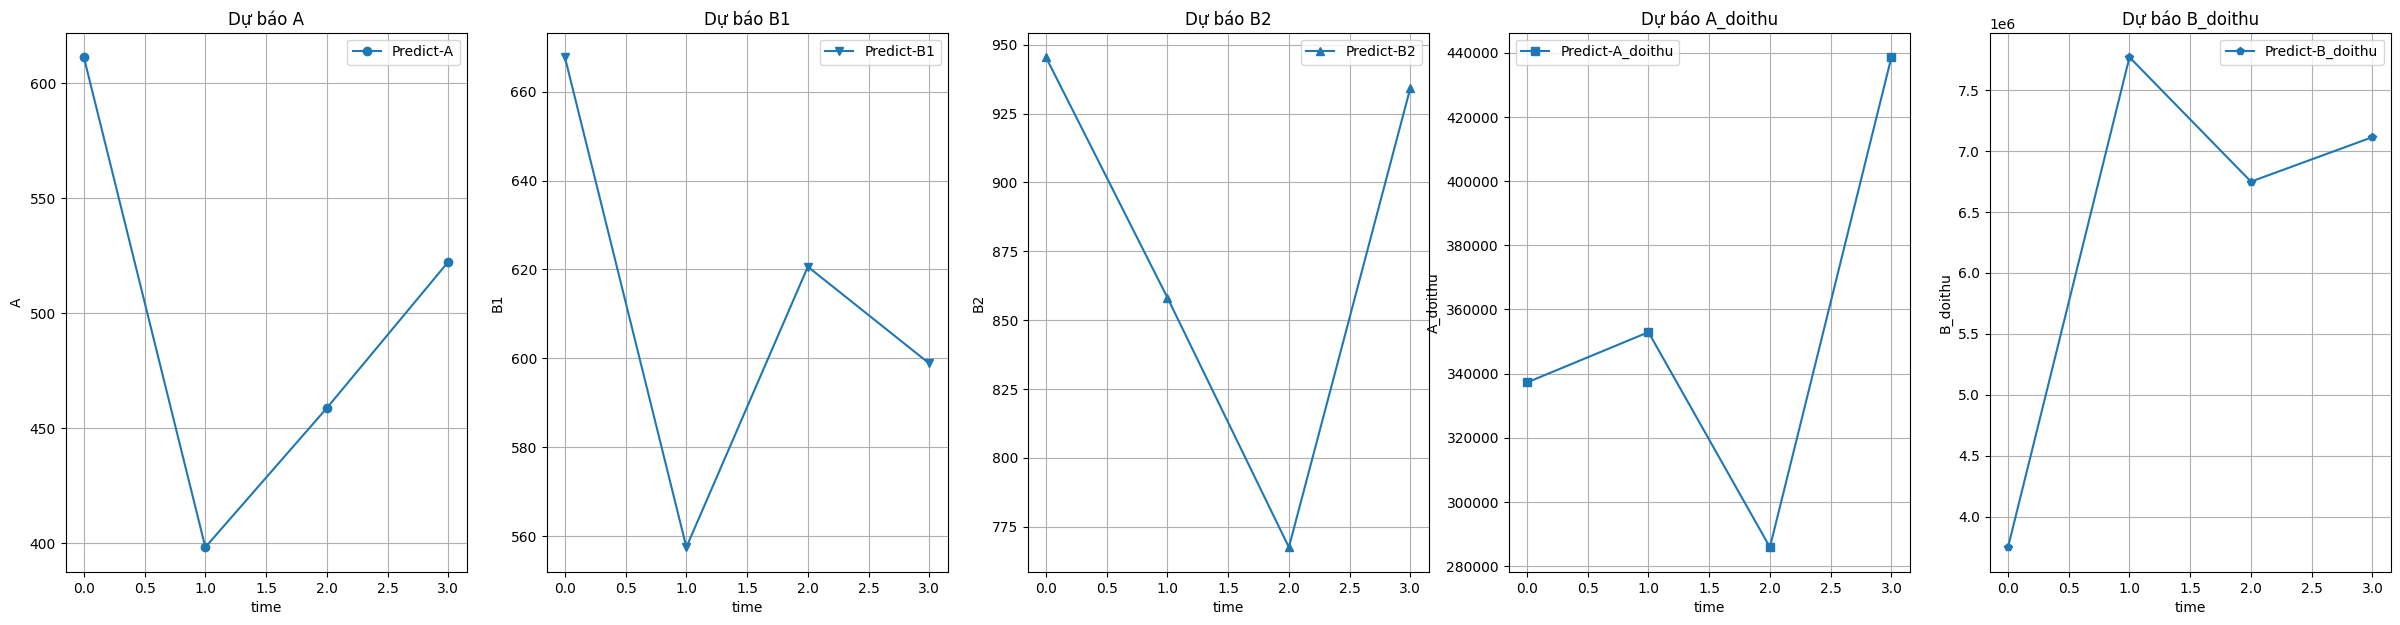

In [60]:
data_train = data.iloc[4:15]
data_test = data.iloc[4:15]
data_train = data_train[features]
data_test= data_test[features]
initial_values = np.array([0.1, 0.1, 0.1])
boundaries = [(0, 1), (0, 1), (0,1)]
parameters = fmin_l_bfgs_b(
sum_obj_function_result, x0=initial_values, args=(4, data_train), bounds=boundaries, approx_grad=True
)
alpha, beta, gamma = parameters[0]
predict0,re0 = preidict_Holt(alpha, beta, gamma, 4, data_train, step = 11)

j = 0
for i in data_test.columns:
    print(f'cột {i}: MAE = {mean_absolute_error(predict0[j], data_test[i])}')
    j = j+1
predict01,re01 = preidict_Holt(alpha, beta, gamma, 4, data_train, step = 5)
predict01 = [predict01[i][1:] for i in range(len(predict01))]
f = plot_predict(predict01, data_train.columns)
predict01

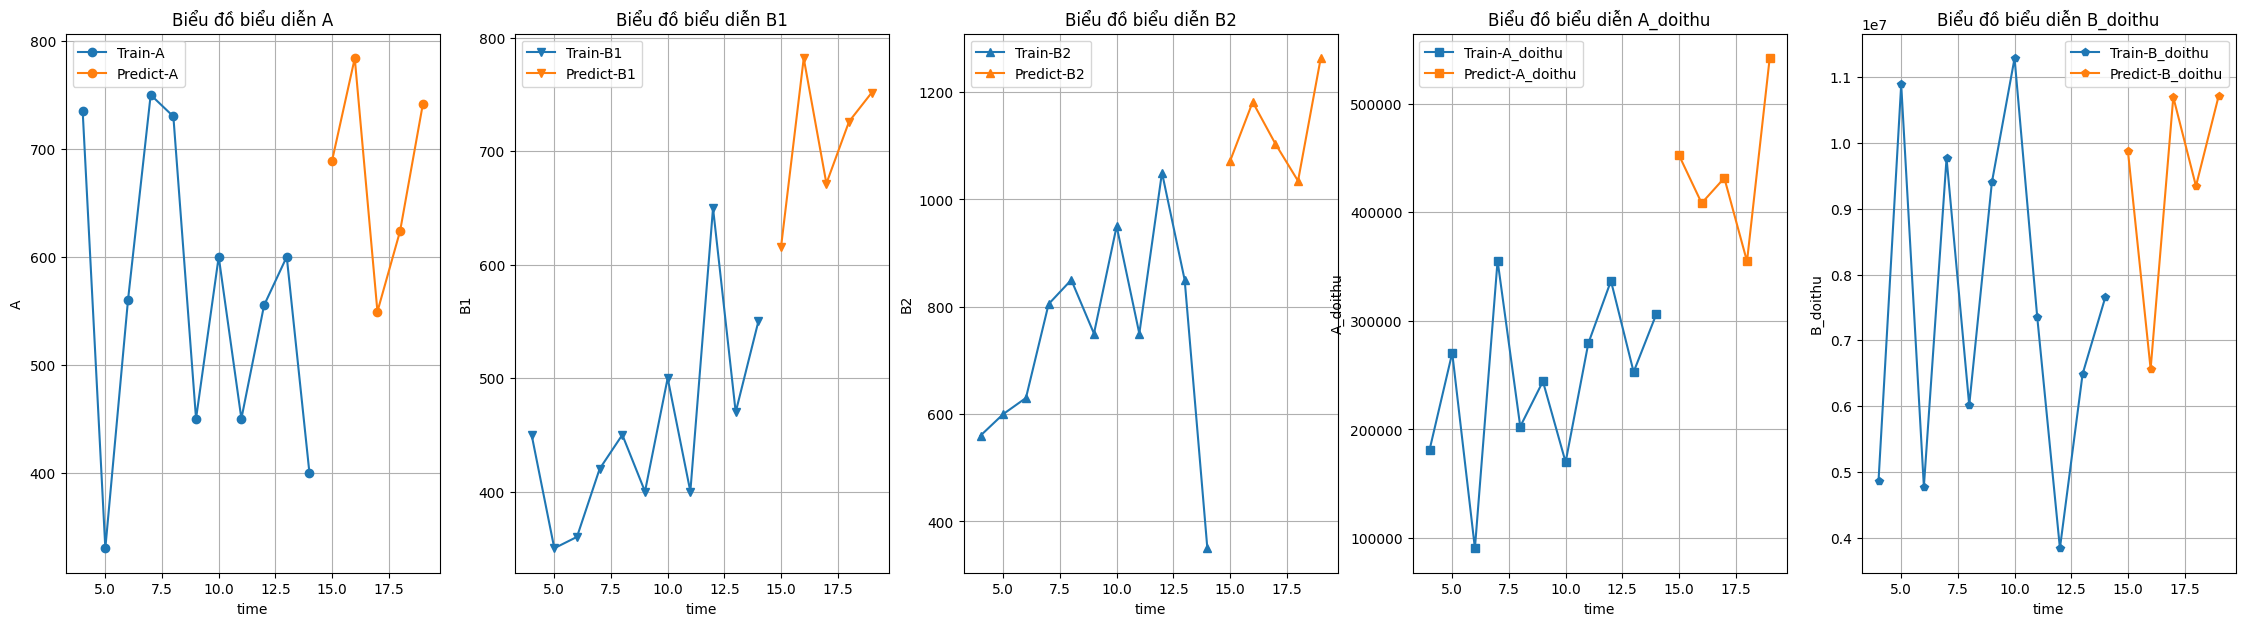

In [59]:
features = ['A', 'B1', 'B2', 'A_doithu', 'B_doithu']
data_train = data.iloc[4:15]
data_test = data.iloc[11:15]
data_train = data_train[features]
data_test= data_test[features]

initial_values = np.array([0.1, 0.1, 0.1])
boundaries = [(0, 1), (0, 1), (0,1)]
parameters1 = fmin_l_bfgs_b(
sum_obj_MSE, x0=initial_values, args=(4, data_train), bounds=boundaries, approx_grad=True
)
alpha1, beta1, gamma1 = parameters1[0]
predict1,re1 = preidict_Holt(alpha1, beta1, gamma1, 4, data_train, step = 5)

j = 0
# for i in data_test.columns:
#     print(f'cột {i}: MAE = {mean_absolute_error(predict1[j], data_test[i])}')
#     j = j+1

figre = plot_evaluate(data_train, predict1)



cột A: MAE = 185.4589316681946
cột B1: MAE = 365.5346468212505
cột B2: MAE = 537.5305833964576
cột A_doithu: MAE = 253827.9892390813
cột B_doithu: MAE = 3605501.806048149


[[[783.931851934297],
  [549.1870683035614],
  [623.9127929740798],
  [741.065624243688]],
 [[782.0782781401044],
  [671.6083025831501],
  [726.248934644517],
  [751.7745011916525]],
 [[1181.535603284432],
  [1103.7081017240203],
  [1034.3905464678105],
  [1263.1080698000187]],
 [[408328.90536840155],
  [431537.4126528173],
  [354718.7652526421],
  [541828.3091887458]],
 [[6563700.954673873],
  [10697519.506289057],
  [9344292.680283641],
  [10713969.767445447]]]

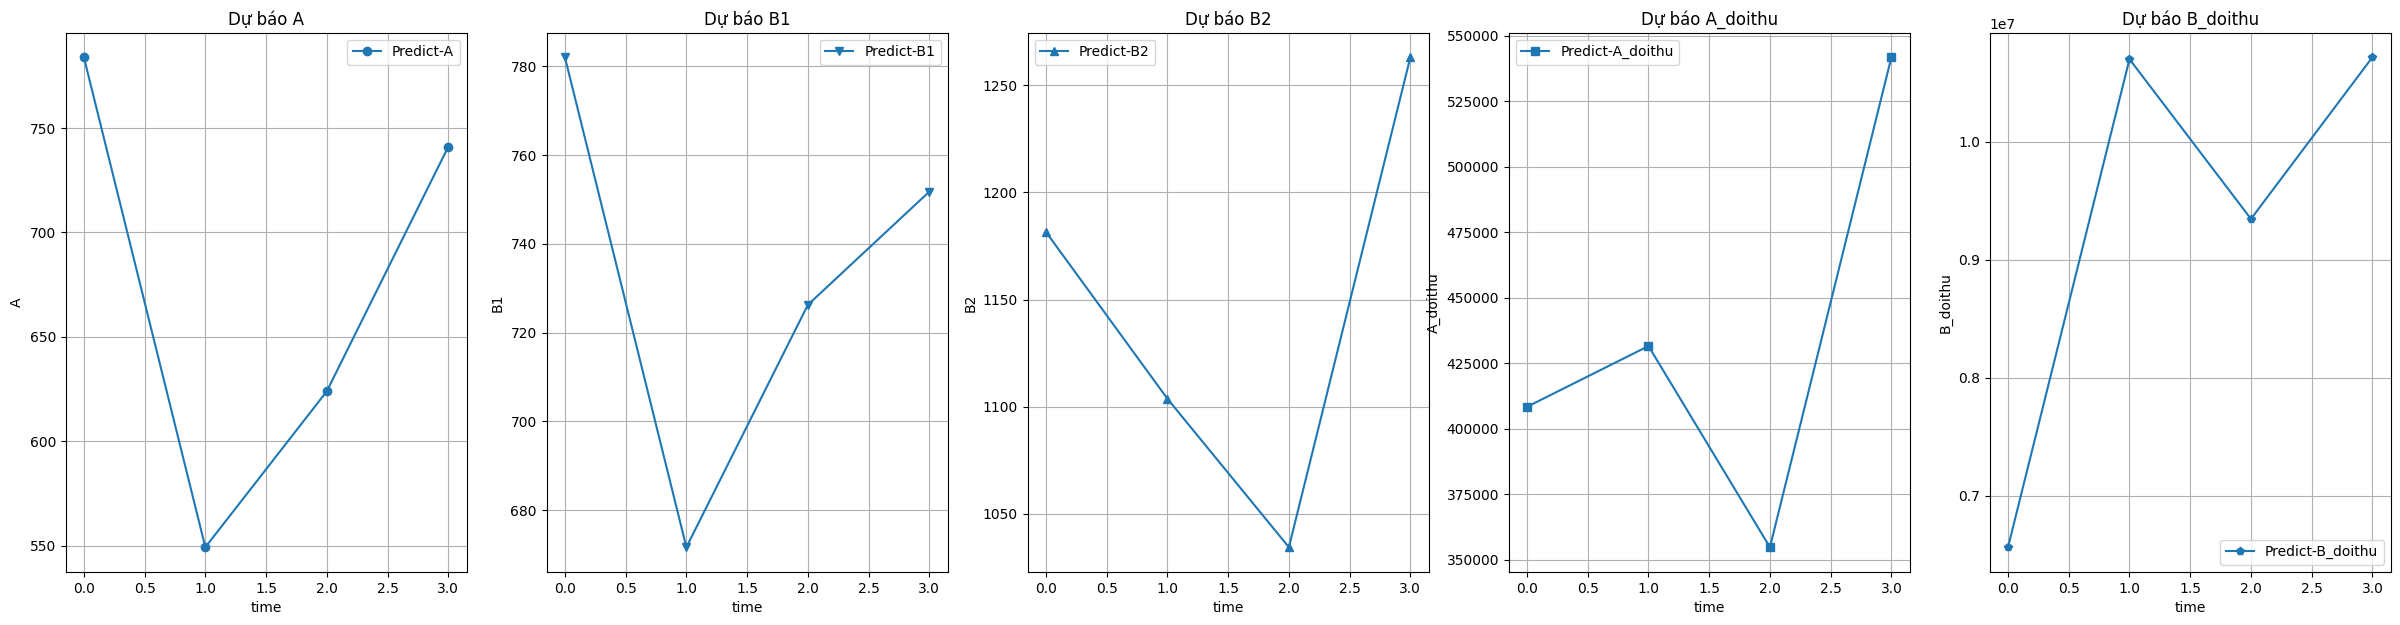

In [61]:
data_train = data.iloc[4:15]
data_test = data.iloc[4:15]
data_train = data_train[features]
data_test= data_test[features]
initial_values = np.array([0.1, 0.1, 0.1])
boundaries = [(0, 1), (0, 1), (0,1)]
parameters = fmin_l_bfgs_b(
sum_obj_MSE, x0=initial_values, args=(4, data_train), bounds=boundaries, approx_grad=True
)
alpha, beta, gamma = parameters[0]
predict0,re0 = preidict_Holt(alpha, beta, gamma, 4, data_train, step = 11)

j = 0
for i in data_test.columns:
    print(f'cột {i}: MAE = {mean_absolute_error(predict0[j], data_test[i])}')
    j = j+1
predict01,re01 = preidict_Holt(alpha, beta, gamma, 4, data_train, step = 5)
predict01 = [predict01[i][1:] for i in range(len(predict01))]
f = plot_predict(predict01, data_train.columns)
predict01